In [1]:
from nepal.datasets import Vaccinations, NYTimes, GovernmentResponse, PopulationDensity
from nepal.ml.features.preprocess import Cases, GovernmentMeasures, Population

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
vaccinations = Vaccinations().load()
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Booster_Doses_Vax_Pct_UR_Equity,Booster_Doses_12PlusVax_Pct_UR_Equity,Booster_Doses_18PlusVax_Pct_UR_Equity,Booster_Doses_65PlusVax_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_5to17Pop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,2022-05-21,02090,20,Fairbanks North Star Borough,AK,97.5,66199.0,68.4,66169.0,73.8,...,2.0,2.0,2.0,3.0,96849,89670,15825,80563,73845,10828
1,2022-05-21,UNK,20,Unknown County,AK,97.5,15439.0,NaN,15424.0,NaN,...,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2022-05-21,01015,20,Calhoun County,AL,92.5,65339.0,57.5,65336.0,61.0,...,2.0,2.0,2.0,2.0,113605,107037,17905,97757,89132,20547
3,2022-05-21,05087,20,Madison County,AR,90.5,8382.0,50.6,8381.0,54.0,...,3.0,3.0,3.0,2.0,16576,15527,2800,14093,12727,3211
4,2022-05-21,06087,20,Santa Cruz County,CA,97.6,236526.0,86.6,236214.0,90.9,...,4.0,4.0,4.0,3.0,273213,259767,38453,239473,221314,47217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723084,2020-12-13,27007,51,Beltrami County,MN,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,47188,<NA>,<NA>,39001,35342,<NA>
1723085,2020-12-13,55105,51,Rock County,WI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,163354,<NA>,<NA>,139259,125952,<NA>
1723086,2020-12-13,29017,51,Bollinger County,MO,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,12133,<NA>,<NA>,10467,9561,<NA>
1723087,2020-12-13,48347,51,Nacogdoches County,TX,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,65204,<NA>,<NA>,55079,50203,<NA>


In [3]:
fips_to_state = (
    vaccinations.loc[vaccinations["FIPS"] != "UNK", ["FIPS", "Recip_State"]]
    .drop_duplicates()
    .rename(columns={"FIPS": "fips", "Recip_State": "state"})
    .set_index("fips")
)

fips_to_state

,state
fips,
02090,AK
01015,AL
05087,AR
06087,CA
13061,GA
...,...
51185,VA
51640,VA
55007,WI


In [4]:
cases = Cases(NYTimes()).preprocessed()
cases

county           state  cases  deaths  new_cases  \
fips  date                                                               
01001 2020-01-21     Autauga         Alabama      0       0   0.000000   
      2020-01-22     Autauga         Alabama      0       0   0.000000   
      2020-01-23     Autauga         Alabama      0       0   0.000000   
      2020-01-24     Autauga         Alabama      0       0   0.000000   
      2020-01-25     Autauga         Alabama      0       0   0.000000   
...                      ...             ...    ...     ...        ...   
78030 2022-04-07  St. Thomas  Virgin Islands   7206      59   9.714286   
      2022-04-08  St. Thomas  Virgin Islands   7219      59  10.571429   
      2022-04-09  St. Thomas  Virgin Islands   7219      59  10.571429   
      2022-04-10  St. Thomas  Virgin Islands   7219      59  10.571429   
      2022-04-11  St. Thomas  Virgin Islands   7219      59  10.571429   

                  new_deaths  
fips  date                    
01001 2020-01-21         0.0  
      2020-01-22         0.0  
      2020-01-23         0.0  
      2020-01-24         0.0  
      2020-01-25         0.0  
...                      ...  
78030 2022-04-07         0.0  
      2022-04-08         0.0  
      2022-04-09         0.0  
      2022-04-10         0.0  
      2022-04-11         0.0  

[2614640 rows x 6 columns]

In [5]:
endogenous_target = cases[["new_cases"]].join(fips_to_state).groupby(["state", "date"]).sum()
endogenous_target

new_cases
state date                 
AK    2020-01-21   0.000000
      2020-01-22   0.000000
      2020-01-23   0.000000
      2020-01-24   0.000000
      2020-01-25   0.000000
...                     ...
WY    2022-04-07  21.857143
      2022-04-08  18.000000
      2022-04-09  18.000000
      2022-04-10  18.000000
      2022-04-11  18.000000

[43036 rows x 1 columns]

In [6]:
gov_response = GovernmentResponse().load()
state_name_mapping = (
    gov_response.loc[
        (gov_response["CountryCode"] == "USA") & (gov_response["RegionCode"].notna()),
        ["RegionName", "RegionCode"],
    ]
    .drop_duplicates()
    .rename(columns={"RegionName": "state_name", "RegionCode": "state"})
)

state_name_mapping["state"] = state_name_mapping["state"].str[3:]
state_name_mapping.set_index("state", inplace=True)
state_name_mapping

,state_name
state,
AK,Alaska
AL,Alabama
AR,Arkansas
AZ,Arizona
CA,California
CO,Colorado
CT,Connecticut
DC,Washington DC
DE,Delaware


In [27]:
population = Population(PopulationDensity()).preprocessed()
averaged_population = population.join(fips_to_state).groupby("state").mean()

processed_measures = GovernmentMeasures(
    response=GovernmentResponse(), vaccinations=Vaccinations()
).preprocessed()

averaged_measures = (
    processed_measures.join(fips_to_state).groupby(["state", "date"]).mean(engine="numba")
)

exogenous_variables = averaged_population.join(averaged_measures)
exogenous_variables

avg_household_size  pop_density  StringencyIndex  \
state date                                                           
AK    2020-12-13            2.905172     3.042685            65.28   
      2020-12-14            2.905172     3.042685            65.28   
      2020-12-15            2.905172     3.042685            65.28   
      2020-12-16            2.905172     3.042685            65.28   
      2020-12-17            2.905172     3.042685            65.28   
...                              ...          ...              ...   
WY    2022-05-17            2.435652     2.536926            27.78   
      2022-05-18            2.435652     2.536926              NaN   
      2022-05-19            2.435652     2.536926              NaN   
      2022-05-20            2.435652     2.536926              NaN   
      2022-05-21            2.435652     2.536926              NaN   

                  GovernmentResponseIndex  ContainmentHealthIndex  \
state date                                                          
AK    2020-12-13                    58.85                   61.90   
      2020-12-14                    58.85                   61.90   
      2020-12-15                    60.10                   63.33   
      2020-12-16                    60.10                   63.33   
      2020-12-17                    60.10                   63.33   
...                                   ...                     ...   
WY    2022-05-17                      NaN                   35.71   
      2022-05-18                      NaN                     NaN   
      2022-05-19                      NaN                     NaN   
      2022-05-20                      NaN                     NaN   
      2022-05-21                      NaN                     NaN   

                  EconomicSupportIndex  Completeness_pct  \
state date                                                 
AK    2020-12-13                  37.5               0.0   
      2020-12-14                  37.5               0.0   
      2020-12-15                  37.5               0.0   
      2020-12-16                  37.5               0.0   
      2020-12-17                  37.5               0.0   
...                                ...               ...   
WY    2022-05-17                   NaN              97.1   
      2022-05-18                   NaN              97.1   
      2022-05-19                   NaN              97.1   
      2022-05-20                   NaN              97.1   
      2022-05-21                   NaN              97.1   

                  Administered_Dose1_Pop_Pct  \
state date                                     
AK    2020-12-13                    0.000000   
      2020-12-14                    0.000000   
      2020-12-15                    0.000000   
      2020-12-16                    0.000000   
      2020-12-17                    0.000000   
...                                      ...   
WY    2022-05-17                   51.430435   
      2022-05-18                   51.443478   
      2022-05-19                   51.447826   
      2022-05-20                   51.456522   
      2022-05-21                   51.465217   

                  Administered_Dose1_Recip_18PlusPop_Pct  \
state date                                                 
AK    2020-12-13                                0.000000   
      2020-12-14                                0.000000   
      2020-12-15                                0.000000   
      2020-12-16                                0.000000   
      2020-12-17                                0.000000   
...                                                  ...   
WY    2022-05-17                               61.065217   
      2022-05-18                               61.082609   
      2022-05-19                               61.091304   
      2022-05-20                               61.095652   
      2022-05-21                               61.104348   

                  Admi

In [12]:
from nepal.datasets import Dataset


def store(df: pd.DataFrame, name: str) -> None:
    folder = Dataset.ROOT_DIR / "reduced"
    folder.mkdir(parents=True, exist_ok=True)

    df.sort_index(inplace=True)
    df.to_parquet(folder / f"{name}.parquet", engine="pyarrow", index=True)


store(endogenous_target, "endogenous")
store(exogenous_variables, "exogenous")

<AxesSubplot:xlabel='state,date'>

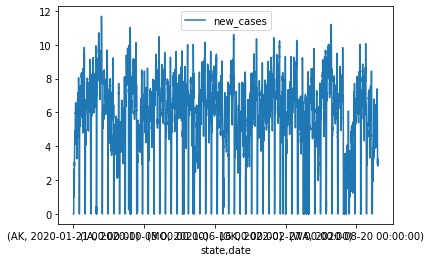

In [13]:
from sklearn.pipeline import Pipeline
from nepal.ml.transformers.functions import LogScaler

preprocess = Pipeline(steps=[("log_scale", LogScaler("new_cases"))])

df_y: pd.DataFrame = preprocess.fit_transform(endogenous_target[["new_cases"]])
df_y.plot()

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.05090543269385101


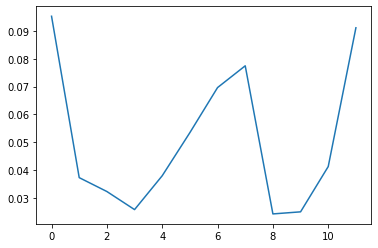

In [24]:
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter

from nepal.ml.loss import mape
from nepal.ml.splitter import Splitter
from nepal.ml.validate import cross_validate
from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.transformers import RollingWindowSum, log_transformer

fh = ForecastingHorizon(list(range(1, 15)))
cv = ExpandingWindowSplitter(fh=fh, initial_window=120, step_length=60)
splitter: Splitter = Splitter(cv)

autoregressive_lag: int = 5
measures_lag: int = 12

transformers: Pipeline = Pipeline(
    [
        (
            "with_active_infections",
            RollingWindowSum(
                "new_cases", target="infections", window=10, transformer=log_transformer
            ),
        ),
    ]
)

forecaster = LGBMForecaster(
    lgb.LGBMRegressor(objective=mape.name), lag=autoregressive_lag, transformers=transformers
)

lagged_measures = exogenous_variables.groupby(level="state").shift(measures_lag)
Xs = (
    lagged_measures
    .groupby(level="state")
    .apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
)

scores = cross_validate(
    forecaster,
    splitter=splitter,
    y=df_y,
    Xs=Xs,
    loss=mape.function,
)

sns.lineplot(data=scores)
print(np.mean(scores))

In [28]:
Xs

avg_household_size  pop_density  StringencyIndex  \
state date                                                           
AK    2020-12-13            2.905172     3.042685            65.28   
      2020-12-14            2.905172     3.042685            65.28   
      2020-12-15            2.905172     3.042685            65.28   
      2020-12-16            2.905172     3.042685            65.28   
      2020-12-17            2.905172     3.042685            65.28   
...                              ...          ...              ...   
WY    2022-05-17            2.435652     2.536926            39.81   
      2022-05-18            2.435652     2.536926            39.81   
      2022-05-19            2.435652     2.536926            39.81   
      2022-05-20            2.435652     2.536926            39.81   
      2022-05-21            2.435652     2.536926            39.81   

                  GovernmentResponseIndex  ContainmentHealthIndex  \
state date                                                          
AK    2020-12-13                    58.85                   61.90   
      2020-12-14                    58.85                   61.90   
      2020-12-15                    58.85                   61.90   
      2020-12-16                    58.85                   61.90   
      2020-12-17                    58.85                   61.90   
...                                   ...                     ...   
WY    2022-05-17                    40.89                   46.73   
      2022-05-18                    40.89                   46.73   
      2022-05-19                    40.89                   46.73   
      2022-05-20                    40.89                   46.73   
      2022-05-21                    40.89                   46.73   

                  EconomicSupportIndex  Completeness_pct  \
state date                                                 
AK    2020-12-13                  37.5               0.0   
      2020-12-14                  37.5               0.0   
      2020-12-15                  37.5               0.0   
      2020-12-16                  37.5               0.0   
      2020-12-17                  37.5               0.0   
...                                ...               ...   
WY    2022-05-17                   0.0              97.1   
      2022-05-18                   0.0              97.1   
      2022-05-19                   0.0              97.1   
      2022-05-20                   0.0              97.1   
      2022-05-21                   0.0              97.1   

                  Administered_Dose1_Pop_Pct  \
state date                                     
AK    2020-12-13                    0.000000   
      2020-12-14                    0.000000   
      2020-12-15                    0.000000   
      2020-12-16                    0.000000   
      2020-12-17                    0.000000   
...                                      ...   
WY    2022-05-17                   51.900000   
      2022-05-18                   51.908696   
      2022-05-19                   51.913043   
      2022-05-20                   51.917391   
      2022-05-21                   51.921739   

                  Administered_Dose1_Recip_18PlusPop_Pct  \
state date                                                 
AK    2020-12-13                                0.000000   
      2020-12-14                                0.000000   
      2020-12-15                                0.000000   
      2020-12-16                                0.000000   
      2020-12-17                                0.000000   
...                                                  ...   
WY    2022-05-17                               61.526087   
      2022-05-18                               61.543478   
      2022-05-19                               61.547826   
      2022-05-20                               61.547826   
      2022-05-21                               61.552174   

                  Admi

In [25]:
import joblib
from nepal.datasets import Dataset

model = forecaster.fit(df_y, Xs=[Xs])

joblib.dump(model, Dataset.ROOT_DIR / "reduced" / "forecaster.joblib")

['/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/datasets/reduced/forecaster.joblib']

In [26]:
from nepal.ml.transformers.functions import LogScaler

LogScaler("new_cases").inverse_transform(model.forecast(fh=fh, y=df_y, Xs=[Xs])).round()

new_cases
state date                 
AK    2022-04-12      131.0
      2022-04-13      132.0
      2022-04-14      132.0
      2022-04-15      132.0
      2022-04-16      132.0
...                     ...
WY    2022-04-21       19.0
      2022-04-22       19.0
      2022-04-23       19.0
      2022-04-24       19.0
      2022-04-25       19.0

[742 rows x 1 columns]